# 이진분류 손실함수로부터 다중 분류의 손실함수 도출

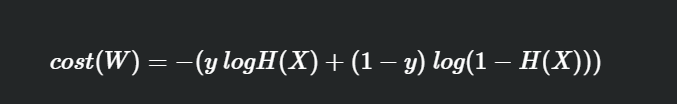

y를 y1, (1-y)를 y2로 치환하면 (이진분류에서는 하나와, 다른 하나인데, 다중에서는 각각으로 판단

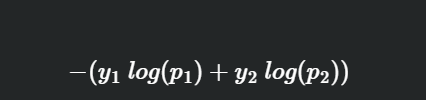

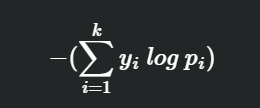

# 소프트맥스 비용함수 구현

In [1]:
import torch
import torch.nn.functional as F

torch.manual_seed(1)

로우 레벨로 구현하기

In [2]:
z = torch.FloatTensor([1, 2, 3])

hypothesis = F.softmax(z, dim=0)
print(hypothesis)

tensor([0.0900, 0.2447, 0.6652])


In [3]:
z = torch.rand(3, 5, requires_grad=True)

In [5]:
z

tensor([[0.7576, 0.2793, 0.4031, 0.7347, 0.0293],
        [0.7999, 0.3971, 0.7544, 0.5695, 0.4388],
        [0.6387, 0.5247, 0.6826, 0.3051, 0.4635]], requires_grad=True)

In [6]:
hypothesis = F.softmax(z, dim=1)
print(hypothesis)

tensor([[0.2645, 0.1639, 0.1855, 0.2585, 0.1277],
        [0.2430, 0.1624, 0.2322, 0.1930, 0.1694],
        [0.2226, 0.1986, 0.2326, 0.1594, 0.1868]], grad_fn=<SoftmaxBackward0>)


In [8]:
# 레이블 만들기

y = torch.randint(5, (3,)).long()
print(y)

tensor([2, 1, 0])


In [9]:
y_one_hot = torch.zeros_like(hypothesis) 
y_one_hot.scatter_(1, y.unsqueeze(1), 1)

tensor([[0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.]])

In [14]:
# 비용함수

cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()
print(cost)

tensor(1.6682, grad_fn=<MeanBackward0>)


하이 레벨로 구현하기

In [15]:
# 소프트맥스의 결과에 로그를 따로 취하지 않고,바로 해결하는 함수

F.log_softmax(z, dim=1)

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]],
       grad_fn=<LogSoftmaxBackward0>)

In [16]:
(y_one_hot * -torch.log(F.softmax(z, dim=1))).sum(dim=1).mean()

tensor(1.6682, grad_fn=<MeanBackward0>)

In [17]:
(y_one_hot * - F.log_softmax(z, dim=1)).sum(dim=1).mean()

tensor(1.6682, grad_fn=<MeanBackward0>)

In [18]:
# 원-핫 벡터를 넣을 필요도 없이 해결하는 함수

F.nll_loss(F.log_softmax(z, dim=1), y)

tensor(1.6682, grad_fn=<NllLossBackward0>)

In [19]:
y

tensor([2, 1, 0])

In [20]:
y_one_hot

tensor([[0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.]])

In [21]:
# 가장 간단하게. F.cross_entropy 비용함수에 소프트맥스 함수까지 포함

F.cross_entropy(z, y)


tensor(1.6682, grad_fn=<NllLossBackward0>)

# 소프트맥스 회귀 구현

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [23]:
torch.manual_seed(1)

In [24]:
x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

In [25]:
print(x_train.shape)
print(y_train.shape)

torch.Size([8, 4])
torch.Size([8])


In [26]:
y_one_hot = torch.zeros(8, 3)
y_one_hot.scatter_(1, y_train.unsqueeze(1), 1)
print(y_one_hot.shape)

torch.Size([8, 3])


In [27]:
y_one_hot

tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])

In [28]:
# 모델 초기화
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

In [29]:
nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # 가설
    hypothesis = F.softmax(x_train.matmul(W) + b, dim=1) 

    # 비용 함수
    cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.761050
Epoch  200/1000 Cost: 0.689991
Epoch  300/1000 Cost: 0.643229
Epoch  400/1000 Cost: 0.604117
Epoch  500/1000 Cost: 0.568255
Epoch  600/1000 Cost: 0.533922
Epoch  700/1000 Cost: 0.500291
Epoch  800/1000 Cost: 0.466908
Epoch  900/1000 Cost: 0.433507
Epoch 1000/1000 Cost: 0.399962


In [30]:
# 모델 초기화
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # Cost 계산
    z = x_train.matmul(W) + b
    cost = F.cross_entropy(z, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.761050
Epoch  200/1000 Cost: 0.689991
Epoch  300/1000 Cost: 0.643229
Epoch  400/1000 Cost: 0.604117
Epoch  500/1000 Cost: 0.568256
Epoch  600/1000 Cost: 0.533922
Epoch  700/1000 Cost: 0.500291
Epoch  800/1000 Cost: 0.466908
Epoch  900/1000 Cost: 0.433507
Epoch 1000/1000 Cost: 0.399962


# 소프트맥스 회귀 nn.Module로 구현하기

In [32]:
class SoftmaxClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4, 3) # Output이 3!

    def forward(self, x):
        return self.linear(x)

In [33]:
model = SoftmaxClassifierModel()

In [34]:
# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.cross_entropy(prediction, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 20번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 2.637636
Epoch  100/1000 Cost: 0.647903
Epoch  200/1000 Cost: 0.564643
Epoch  300/1000 Cost: 0.511043
Epoch  400/1000 Cost: 0.467249
Epoch  500/1000 Cost: 0.428281
Epoch  600/1000 Cost: 0.391924
Epoch  700/1000 Cost: 0.356742
Epoch  800/1000 Cost: 0.321577
Epoch  900/1000 Cost: 0.285617
Epoch 1000/1000 Cost: 0.250818
